In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
# low-pass filter the altitude data stream in time
# compute the derivative in distance
# Look for places where the:
#    - derivative is zero
#    - derivative goes from being positive (moving uphill) to negative (moving downhill) each side of zero
# These are candidate summit points
# Look for nearest neighbours in the summit database
# Accept any that pass within 20 m of the summit

In [3]:
classification_cols = ['Ma', 'Ma=', 'Hu', 'Hu=', 'Tu', 'Sim', '5', 'M', 'MT', 'F', 'C', 'G', 'D', 'DT', 'Hew', 'N', 'Dew',
                           'DDew', 'HF', '4', '3', '2', '1', '0', 'W', 'WO', 'B', 'Sy', 'Fel', 'CoH', 'CoH=', 'CoU',
                           'CoU=', 'CoA', 'CoA=', 'CoL', 'CoL=', 'SIB', 'sMa', 'sHu', 'sSim', 's5', 's4', 'Mur', 'CT',
                           'GT', 'BL', 'Bg', 'Y', 'Cm', 'T100', 'xMT', 'xC', 'xG', 'xN', 'xDT', 'Dil', 'VL', 'A', 'Ca',
                           'Bin', 'O', 'Un']

In [4]:
classification_codes = {
    'M': 'Munro',
    'MT': 'Munro Top',
    'C': 'Corbett',
    'CT': 'Corbett Top',
    'G': 'Graham',
    'GT': 'Graham Top',
    'D': 'Donald',
    'DT': 'Donald Top',
    'Ma': 'Marilyn',
    'Hu': 'Hump',
    'Tu': 'Tump',
    'Sim': 'Simm',
    'Hew': 'Hewitt',
    'N': 'Nutall',
    'W': 'Wainwright,'
}

In [5]:
with open('streamset.json', 'r') as file:
    data = json.load(file)

In [6]:
lat = np.array(data['latlng']['data'])[:, 0]
lng = np.array(data['latlng']['data'])[:, 1]

In [7]:
columns = data.keys()
df = pd.DataFrame()

for col in columns:
    df[col] = data[col]['data']
    
df['lat'] = lat
df['lng'] = lng

df

,moving,latlng,distance,altitude,heartrate,time,lat,lng
0,False,"[56.006965, -4.201626]",0.0,330.2,112,0,56.006965,-4.201626
1,False,"[56.006937, -4.201648]",0.0,330.1,113,1,56.006937,-4.201648
2,True,"[56.006909, -4.201671]",3.9,329.9,113,2,56.006909,-4.201671
3,True,"[56.006881, -4.201695]",7.6,329.8,113,3,56.006881,-4.201695
4,True,"[56.006853, -4.20172]",11.4,329.7,113,4,56.006853,-4.201720
...,...,...,...,...,...,...,...,...
6876,True,"[56.007637, -4.200479]",13321.7,333.6,177,6876,56.007637,-4.200479
6877,True,"[56.007651, -4.20053]",13325.5,333.5,177,6877,56.007651,-4.200530
6878,True,"[56.007665, -4.20058]",13329.8,333.4,178,6878,56.007665,-4.200580
6879,True,"[56.007678, -4.200628]",13333.1,333.3,177,6879,56.007678,-4.200628


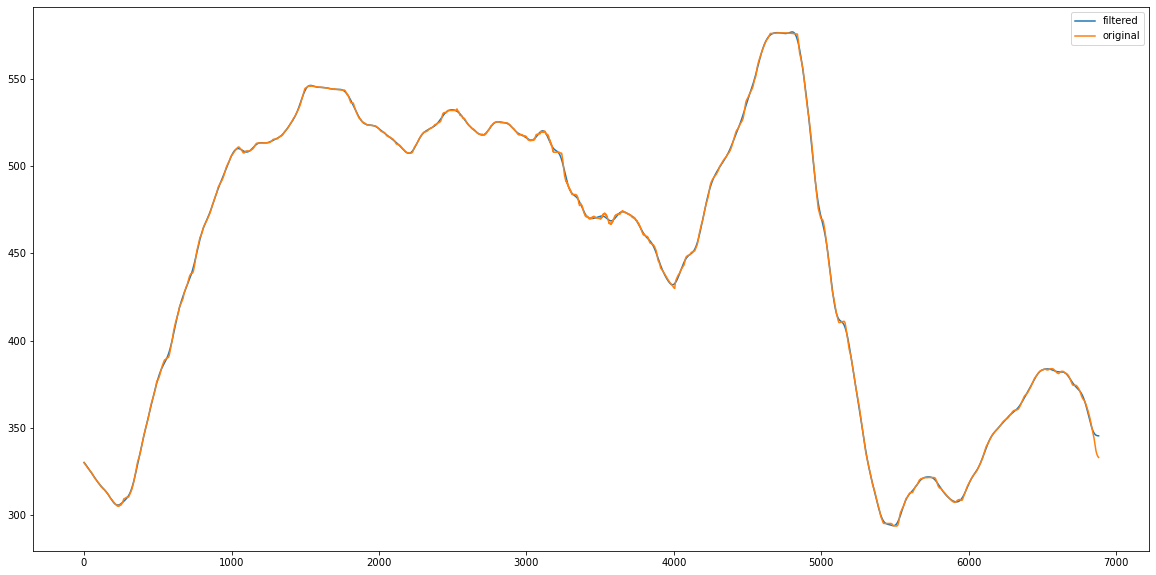

In [8]:
fs = 1  # Sampling frequency Hz
# Generate the time vector properly
t = df['time']
sig = df['altitude']

fc = 0.01  # Cut-off frequency of the filter
w = fc / (fs / 2) # Normalize the frequency
b, a = signal.butter(5, w, 'low')
output = signal.filtfilt(b, a, sig)
dist = signal.filtfilt(b, a, df['distance'])
plt.figure(figsize=(20, 10))
plt.plot(t, output, label='filtered')
plt.plot(t, sig, label='original')
plt.legend()
plt.show()

In [9]:
df['alt_filtered'] = output
maxima, properties = signal.find_peaks(df['alt_filtered'].values)
df['max'] = False
df.loc[maxima, 'max'] = True
df

,moving,latlng,distance,altitude,heartrate,time,lat,lng,alt_filtered,max
0,False,"[56.006965, -4.201626]",0.0,330.2,112,0,56.006965,-4.201626,330.293235,False
1,False,"[56.006937, -4.201648]",0.0,330.1,113,1,56.006937,-4.201648,330.195100,False
2,True,"[56.006909, -4.201671]",3.9,329.9,113,2,56.006909,-4.201671,330.095305,False
3,True,"[56.006881, -4.201695]",7.6,329.8,113,3,56.006881,-4.201695,329.993904,False
4,True,"[56.006853, -4.20172]",11.4,329.7,113,4,56.006853,-4.201720,329.890948,False
...,...,...,...,...,...,...,...,...,...,...
6876,True,"[56.007637, -4.200479]",13321.7,333.6,177,6876,56.007637,-4.200479,345.590538,False
6877,True,"[56.007651, -4.20053]",13325.5,333.5,177,6877,56.007651,-4.200530,345.583147,False
6878,True,"[56.007665, -4.20058]",13329.8,333.4,178,6878,56.007665,-4.200580,345.577085,False
6879,True,"[56.007678, -4.200628]",13333.1,333.3,177,6879,56.007678,-4.200628,345.572172,False


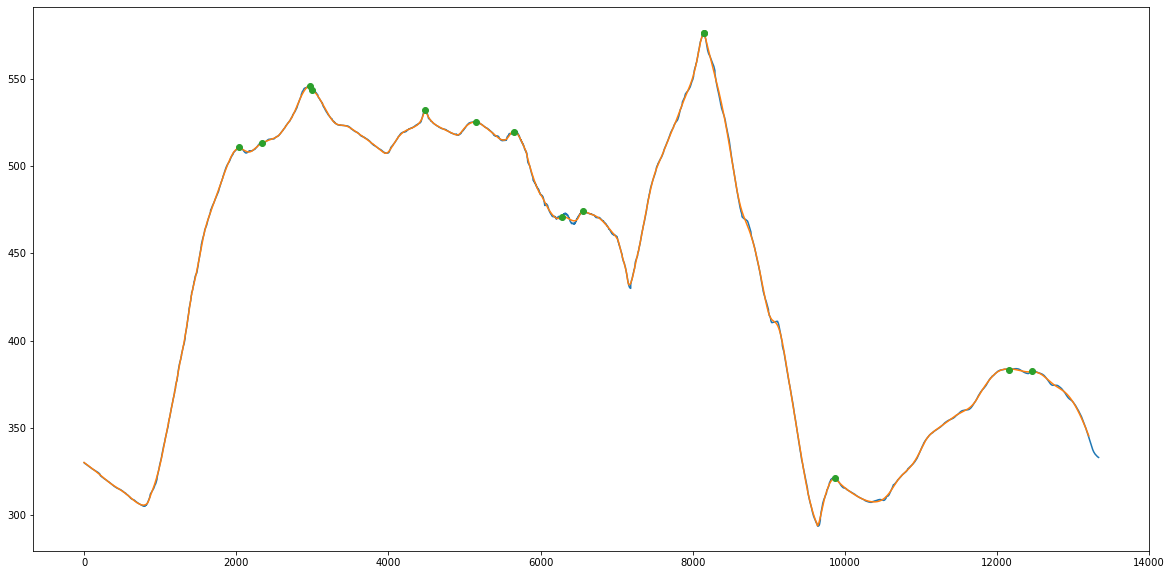

In [10]:
plt.figure(figsize=(20, 10))
plt.plot(df['distance'], df['altitude'])
plt.plot(dist, df['alt_filtered'])

peaks = df.loc[df['max']]
plt.plot(peaks['distance'], peaks['altitude'], 'o')

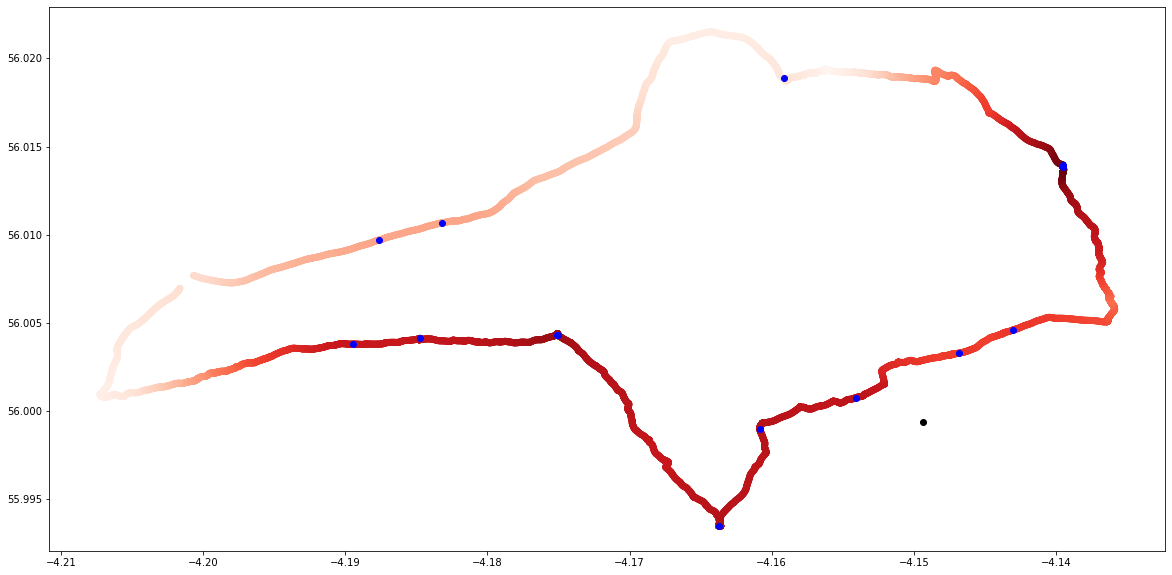

In [11]:
plt.figure(figsize=(20, 10))
plt.scatter(df['lng'], df['lat'], c=df['altitude'], cmap='Reds')
plt.scatter(peaks['lng'], peaks['lat'], c='blue')

plt.scatter([-4.149319], [55.999408], c='k')

In [12]:
hills_database = pd.read_csv('./DoBIH_v17_3.csv', index_col=0)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (3,25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [13]:
db = hills_database[['Name', 'Latitude', 'Longitude', 'Metres', 'Classification']+classification_cols]

In [14]:
db

,Name,Latitude,Longitude,Metres,Classification,Ma,Ma=,Hu,Hu=,Tu,...,xG,xN,xDT,Dil,VL,A,Ca,Bin,O,Un
Number,,,,,,,,,,,,,,,,,,,,,
1,Ben Chonzie,56.453851,-3.992057,931.0,"Ma,M,Sim",1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,Creagan na Beinne,56.506927,-4.041692,888.0,"Ma,C,Sim",1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,Creag Uchdag,56.465278,-4.098107,879.0,"Ma,C,Sim",1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Auchnafree Hill,56.454346,-3.934667,789.0,"Ma,C,Sim",1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Shee of Ardtalnaig [Ciste Buide a' Claidheimh],56.491391,-4.064980,759.0,"Ma,G,Sim",1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21450,Pigeon Rock North,54.158563,-6.070387,534.0,"A,s5",0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
21451,Rathmacullig,51.847490,-8.460914,175.0,CoU,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21452,An Chruach Ghorm (mullach thoir) [Croaghgorm E...,54.752542,-8.059764,594.0,s5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
height_threshold = 50
max_search_height = peaks['altitude'].max() + height_threshold
min_search_height = peaks['altitude'].min() - height_threshold

candidate_hills = db.loc[(db['Metres']>min_search_height) & (db['Metres']<max_search_height)]
candidate_hills

,Name,Latitude,Longitude,Metres,Classification,Ma,Ma=,Hu,Hu=,Tu,...,xG,xN,xDT,Dil,VL,A,Ca,Bin,O,Un
Number,,,,,,,,,,,,,,,,,,,,,
12,Meall nan Caorach,56.484896,-3.741233,623.7,"Ma,G,Sim",1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
13,Meall Reamhar,56.479061,-3.751683,617.8,"Ma,G,Sim",1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
14,Creag na Criche,56.496882,-3.649101,456.8,"Ma,4",1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
15,Birnam Hill - King's Seat,56.543579,-3.575758,403.8,"Ma,4",1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
16,Knock of Crieff,56.389338,-3.826990,279.0,"Ma,2",1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21444,Spinans Hill SE Top,52.962933,-6.616714,400.0,4,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
21445,Slieve Felim E Top,52.670523,-8.283069,423.0,4,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
21450,Pigeon Rock North,54.158563,-6.070387,534.0,"A,s5",0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [16]:
from typing import Union

def vector_haversine(lon1: Union[np.array, float],
                     lat1: Union[np.array, float],
                     lon2: Union[np.array, float],
                     lat2: Union[np.array, float]) -> Union[np.array, float]:
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.square(np.sin(0.5 * dlat)) + np.cos(lat1) * np.cos(lat2) * np.square(np.sin(0.5 * dlon))
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r * 1000.

def calculate_nearest_neighbours_5(local_maxima: pd.DataFrame, hills_df: pd.DataFrame) -> pd.DataFrame:
    lat_peaks = np.radians(local_maxima['lat'].values)
    lng_peaks = np.radians(local_maxima['lng'].values)
    
    lat_hills = np.radians(hills_df['Latitude'].values)
    lng_hills = np.radians(hills_df['Longitude'].values)

    lat_peaks, lat_hills = np.meshgrid(lat_peaks, lat_hills, sparse=True)
    lng_peaks, lng_hills = np.meshgrid(lng_peaks, lng_hills, sparse=True)

    distance_matrix = vector_haversine(lng_hills, lat_hills, lng_peaks, lat_peaks)

    minimum_indices = np.argmin(distance_matrix, axis=0)
    distances = distance_matrix[minimum_indices, range(len(local_maxima))]

    return distances, minimum_indices

In [17]:
distances, idx = calculate_nearest_neighbours_5(peaks, candidate_hills)

In [18]:
peaks.loc[:, 'named_hill_closest_distance'] = distances
peaks.loc[:, 'named_hill_index'] = idx
peaks

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,moving,latlng,distance,altitude,heartrate,time,lat,lng,alt_filtered,max,named_hill_closest_distance,named_hill_index
1045,True,"[56.003798, -4.189429]",2034.8,510.8,161,1045,56.003798,-4.189429,510.033585,True,895.948609,3322
1202,False,"[56.004117, -4.184756]",2335.7,513.2,142,1202,56.004117,-4.184756,513.352689,True,604.086207,3322
1535,False,"[56.004312, -4.175073]",2973.3,545.8,149,1535,56.004312,-4.175073,546.145268,True,4.188551,3322
1725,False,"[56.004291, -4.175043]",2996.6,543.8,88,1725,56.004291,-4.175043,543.902037,True,1.446870,3322
2495,False,"[55.993492, -4.16373]",4474.0,531.8,90,2495,55.993492,-4.163730,532.176954,True,1111.676109,2233
2808,True,"[55.999008, -4.160843]",5149.1,525.3,159,2808,55.999008,-4.160843,525.295558,True,717.949310,2233
3110,True,"[56.000768, -4.154057]",5655.4,519.5,124,3110,56.000768,-4.154057,520.150259,True,331.151579,2233
3513,True,"[56.003295, -4.146789]",6280.1,471.0,116,3513,56.003295,-4.146789,471.384831,True,459.951592,2233
3653,True,"[56.004593, -4.143054]",6559.2,474.1,108,3653,56.004593,-4.143054,473.839527,True,695.802822,2233
4701,False,"[56.013846, -4.139501]",8142.9,576.2,87,4701,56.013846,-4.139501,576.347476,True,8.749698,472


In [19]:
threshold_distance = 10

closest_points = pd.DataFrame(peaks.groupby('named_hill_index')['named_hill_closest_distance'].min())
closest_points['is_within_threshold'] = closest_points['named_hill_closest_distance'] < threshold_distance
closest_points

,named_hill_closest_distance,is_within_threshold
named_hill_index,,
472,3.463550,True
2233,331.151579,False
3322,1.446870,True


In [20]:
hills_to_report = closest_points.loc[closest_points['is_within_threshold']].index
hill_report_data = candidate_hills.iloc[hills_to_report]
hill_report_data

,Name,Latitude,Longitude,Metres,Classification,Ma,Ma=,Hu,Hu=,Tu,...,xG,xN,xDT,Dil,VL,A,Ca,Bin,O,Un
Number,,,,,,,,,,,,,,,,,,,,,
1657,Meikle Bin,56.013923,-4.139472,570.0,"Ma,5,DDew",1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
7133,Lecket Hill,56.004278,-4.175044,547.0,"5,DDew,sHu",0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [21]:
df = (hill_report_data[classification_cols] == 1).T

hill_classification_codes = {}
for hill in df.columns:
    classification_series = df[hill]
    classifications = classification_series.loc[classification_series==True].index.to_list()
    hill_classification_codes.update({hill: classifications})
    
hill_classification_codes

{1657: ['Ma', 'Hu', 'Tu', '5', 'DDew', 'Y'], 7133: ['Tu', '5', 'DDew', 'sHu']}

In [22]:
for idx, codes in hill_classification_codes.items():
    long_names = []
    for c in codes:
        long_name = classification_codes.get(c)
        if long_name is not None:
            long_names.append(long_name)
        
    hill_classification_codes.update({idx: long_names})
        
hill_classification_codes

{1657: ['Marilyn', 'Hump', 'Tump'], 7133: ['Tump']}

In [23]:
# primary_classifiers - if one of these, always report it, even if not exclusive
primary_classifiers = ['Munro', 'Corbett', 'Graham', 'Donald', 'Furth', 'Wainwright']
# Don't double report primary classifiers and tops
primary_classifier_tops = ['Munro Top', 'Corbett Top', 'Graham Top', 'Donald Top']

# heirarchical classifiers - only report if something higher in the chain doesn't exist
hierarchical_classifiers = pd.Series(data={
    1: 'Hewitt',
    2: 'Nutall',
    3: 'Marilyn',
    4: 'Hump',
    5: 'Tump',
}) 

In [49]:
def reduce_classification_list(hill_classification_codes):
    last = {}

    for idx, codes in hill_classification_codes.items():
        final_codes = []
        highest_rank = hierarchical_classifiers.index.max()
        
        is_primary = np.any([c in primary_classifiers for c in codes])
        is_primary_top = np.any([c in primary_classifier_tops for c in codes])
        
        # print(f'is primary? {is_primary}')
        # print(f'is primary top? {is_primary_top}')
            
        for c in codes:
            if is_primary and c in primary_classifiers:
                final_codes.append(c)
            
            if is_primary_top and not is_primary and c in primary_classifier_tops:
                final_codes.append(c)
                
            if not(is_primary or is_primary_top):
                rank = hierarchical_classifiers.loc[hierarchical_classifiers==c].index.values
                if len(rank):
                    rank = rank[0]
                    
                    if rank <= highest_rank:
                        highest_rank = rank
                        final_codes.append(c)

        last.update({idx: final_codes})
        
    return last

In [50]:
test = {1657: ['Joe', 'Sam'], 7133: ['joe']}

reported_classifications = reduce_classification_list(hill_classification_codes)
# reported_classifications = reduce_classification_list(test)
reported_classifications

{1657: [], 7133: []}

In [51]:
hill_report_data

,Name,Latitude,Longitude,Metres,Classification,Ma,Ma=,Hu,Hu=,Tu,...,xG,xN,xDT,Dil,VL,A,Ca,Bin,O,Un
Number,,,,,,,,,,,,,,,,,,,,,
1657,Meikle Bin,56.013923,-4.139472,570.0,"Ma,5,DDew",1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
7133,Lecket Hill,56.004278,-4.175044,547.0,"5,DDew,sHu",0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [52]:
def generate_hill_info_string(hill_id, hill_data):
    name = hill_data.loc[hill_id, 'Name']
    height = hill_data.loc[hill_id, 'Metres']
    return f'{name} ({height} m)'

In [53]:
df = pd.DataFrame(columns = primary_classifiers+primary_classifier_tops+hierarchical_classifiers.to_list())

for idx, rc in reported_classifications.items():
    df.loc[idx, :] = False
    df.loc[idx, rc] = True

hill_info_strings = {}
    
for classification in df.columns:
    hills = df.loc[df[classification]].index
    
    if hills.any():
        info_strings = []
        for hill in hills:
            info_strings.append(generate_hill_info_string(hill, hill_report_data))
        hill_info_strings.update({classification+'s': ', '.join(info_strings)})

hill_info_strings

{}

In [55]:
def generate_report(hill_info):
    if not len(hill_info):
        return None
    
    report = 'Summits visited:\n\n'
    for classification, info in hill_info.items():
        report += classification+':\n'
        report += info+'\n\n'
        
    return report
        
print(generate_report(hill_info_strings))

None
